In [3]:
%pip install langgraph langchain langchain_openai langchain_community aiosqlite
%pip install -q langfuse
%pip install pytrends

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, getpass, requests
import random
import aiosqlite
import uuid
import nest_asyncio
from pathlib import Path
import datetime

from typing import TypedDict, List, Optional, Annotated
from IPython.display import Image, display

from pytrends.request import TrendReq

from langfuse import Langfuse
from langfuse.callback import CallbackHandler

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.types import interrupt, Command
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")
_set_env("LANGFUSE_HOST")
_set_env("LANGCHAIN_API_KEY")
_set_env("LANGCHAIN_TRACING_V2")
_set_env("UNSPLASH_ACCESS_KEY")
_set_env("UNSPLASH_SECRET")
_set_env("GOOGLE_API_KEY")
_set_env("GOOGLE_CSE_ID")

langfuse = Langfuse(
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    host=os.environ["LANGFUSE_HOST"]
)

langfuse_handler = CallbackHandler()

DB_PATH = Path("./articles.sqlite")
conn = aiosqlite.connect(DB_PATH)
memory = AsyncSqliteSaver(conn)

NameError: name 'AsyncSqliteSaver' is not defined

In [ ]:
class Draft(TypedDict):
    title: str
    body: str
    images: List[str]

def update_draft(left: Draft | None, right: Draft | None) -> Draft:
    if left is None:
        return right
    if right is None:
        return left
    draft = Draft(
        title=right["title"] if right["title"] != "" else left["title"] if left else "",
        body=right["body"] if right["body"] != "" else left["body"] if left else "",
        images=right["images"] if right["images"] != [] else left["images"] if left else []
    )
    return draft

class Source(TypedDict):
    title: str
    url: str
    content: str
    score: float

class State(MessagesState):
    prompt: str
    topic: str
    sources: Optional[List[Source]]
    draft: Annotated[Draft, update_draft]
    article: Optional[str]
    feedback_title: str
    feedback_body: str
    feedback_images: str

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    streaming=True,
    verbose=True,
    callbacks=[langfuse_handler],
)

tavily = TavilySearchResults(max_results=5)

In [ ]:
def get_user_prompt_node(state: State) -> State:
    '''
    Get the user prompt node.
    '''
    prompt = input(
        "Inserisci il prompt per l'articolo: "
    )

    return { "prompt": prompt }

In [ ]:
def router_node(state: State) -> State:
    '''
    Decide whether to extract a topic or call the tool to get trending topics.
    If the user has clearly provided a topic, extract it.
    Otherwise, trigger the get_trending_topics tool.
    '''
    
    messages = [
        {
            "role": "system",
            "content": '''
                You are a helpful assistant that decides if a user has provided a clear article topic or needs suggestions.

                - If the user prompt clearly contains a topic, extract it as a short phrase.
                  For example, "How to train a dog" -> "dog training" or "The history of the internet" -> "internet history".
                
                - If the user is asking for suggestions or is too vague, respond with a function call to `get_trending_topics`.
                  For example, "What should I write about?" or "I need ideas for an article" should trigger the function call.
                
                Respond ONLY in one of the following formats:
                - To extract a topic: "topic: <topic>"
                - To call the function: "function: get_trending_topics"
                '''
        },
        {
            "role": "user",
            "content": state["prompt"]
        }
    ]

    response = llm.invoke(messages)
    content = response.content

    print(f"Response: {content}")

    if content.startswith("topic:"):
        topic = content.split("topic:")[1].strip()
        return { "topic": topic }
    elif content.startswith("function:"):
        return { "topic": None }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [ ]:
def get_trending_topics_node(state: State) -> State:
    '''
    Get three the trending topics from Google Trends.
    Returns them and asks the user to choose one.
    Exclude the topics already proposed to the user.
    '''

    exclude = state.get("trending_topics", None)

    print(f"Excluding topics: {exclude}")

    pytrends = TrendReq()
    trends = pytrends.interest_over_time()

    print(f"Trends: {trends}")

    if exclude is not None:
        trends = [t for t in trends if t not in exclude]

    return { "trending_topics": random.sample(trends, 3) }

In [ ]:
def get_sources_node(state: State) -> State:
    '''
    Use Tavily to search for high-quality sources based on the topic.
    Filters results with score > 0.7 and keeps structured data.
    '''
    
    results = tavily.invoke({ "query": state["topic"] })

    formatted_results: List[Source] = [
        Source(
            title=r.get("title", ""),
            url=r.get("url", ""),
            content=r.get("content", ""),
            score=r.get("score", 0),
        )
        for r in results if r.get("score", 0) > 0.7
    ]

    return { "sources": formatted_results }

In [ ]:
def suggest_or_choose_topic_node(state: State) -> State:
    '''
    Suggest the trending topics to the user and ask him to choose one.
    Extract the topic from the user input if he chooses one, otherwise call the function again.
    '''
    
    trending_topics = state.get("trending_topics")

    suggestions = "\n".join([f"{i+1}. {t}" for i, t in enumerate(trending_topics)])
    print(f"\nEcco tre topic di tendenza:\n{suggestions}\n")

    user_reply = input("Scrivi il topic che preferisci (anche non presente nella lista) o chiedi di vederne altri: ")

    messages = [
        {
            "role": "system",
            "content": '''
                You are a helpful assistant who suggests trending topics to the user and helps him choose one.

                You have suggested the following topics:
                {suggestions}

                Interpret the user reply:
                - If the user chooses one of the suggested topics, extract it.
                - If the user suggests a different topic, extract that.
                - If the user asks for more suggestions, respond exactly with "more_topics".

                Respond ONLY in one of the following formats:
                - To extract a topic: "topic: <topic>"
                - To get more topics: "more_topics"
                '''
        },
        {
            "role": "user",
            "content": user_reply
        }
    ]

    response = llm.invoke(messages=messages)
    content = response.content.strip()

    if content.startswith("topic:"):
        topic = content.split("topic:")[1].strip()
        return { "topic": topic }
    elif content == "more_topics":
        return { "topic": None }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [ ]:
def generate_title_node(state: State) -> State:
    '''
    Generate a title for the article based on the topic and sources.
    '''
    if state.get("feedback_title") is not None:
        prompt = f'''
        You are an expert article writer. Based on the following topic and sources, generate a catchy and clickbait title for the article.
        Base your title also on the feedback, IF GIVEN.
        If the feedback is null, ignore it.
        The title MUST BE IN ITALIAN🇮🇹🇮🇹🇮🇹🇮🇹🇮🇹.

        Topic: {state["topic"]}
        Sources: {state["sources"]}
        Feedback: {state["feedback_title"]}

        The title should be engaging and reflect the content of the article. Exagerate the topic and make it sound interesting.
        The title should be no more than 10 words long and should not contain any special characters or numbers.
        For example, if the topic is "dog training" and the sources are about dog training techniques, a possible title could be "The Ultimate Guide to Dog Training: Tips and Tricks".
        Only return the title.
        Do not include any additional text or explanations.
        '''
    else:
        prompt = f'''
        You are an expert article writer. Based on the following topic and sources, generate a catchy and clickbait title for the article.
        The title MUST BE IN ITALIAN🇮🇹🇮🇹🇮🇹🇮🇹🇮🇹.

        Topic: {state["topic"]}
        Sources: {state["sources"]}

        The title should be engaging and reflect the content of the article. Exagerate the topic and make it sound interesting.
        The title should be no more than 10 words long and should not contain any special characters or numbers.
        For example, if the topic is "dog training" and the sources are about dog training techniques, a possible title could be "The Ultimate Guide to Dog Training: Tips and Tricks".
        Only return the title.
        Do not include any additional text or explanations.
        '''

    response = llm.invoke(prompt)
    
    title = response.content.strip()
    print(f"Title: {title}")
    return {
        "draft": {
            "title": title,
            "body": "",
            "images": []
        }
    }

In [ ]:
def generate_draft_node(state: State) -> State:
    '''
    Generate a draft for the article based on the topic and sources.
    '''

    urls = [source["url"] for source in state["sources"] if source["url"]]
    sources = "\n".join(urls)

    if state.get("feedback_body") is not None:
        prompt = f'''
        Sei un esperto scrittore di articoli.
        Devi basarti sul topic e usare le fonti per generare una bozza di articolo.
        Basati anche sul feedback, SE PRESENTE. Se è vuoto ignoralo.
        L'articolo deve essere in ITALIAN🇮🇹🇮🇹🇮🇹🇮🇹🇮🇹.
        Argomento: {state["topic"]}
        Fonti: {sources}
        Feedback: {state["feedback_body"]}
        L'articolo deve essere coinvolgente e riflettere il contenuto delle fonti.
        La bozza deve essere lunga almeno 500 parole e non deve contenere errori grammaticali o di battitura.
        La bozza deve essere ben strutturata e suddivisa in sezioni con titoli appropriati.
        La bozza deve essere originale e non copiata da altre fonti.
        La bozza deve essere scritta in un linguaggio semplice e comprensibile, evitando termini tecnici o complessi.
        '''
    
    prompt = f'''
    Sei un esperto scrittore di articoli.
    Devi basarti sul topic e usare le fonti per generare una bozza di articolo.
    L'articolo deve essere in ITALIANO🇮🇹🇮🇹🇮🇹🇮🇹🇮🇹.
    Argomento: {state["topic"]}
    Fonti: {sources}
    L'articolo deve essere coinvolgente e riflettere il contenuto delle fonti.
    La bozza deve essere lunga almeno 500 parole e non deve contenere errori grammaticali o di battitura.
    La bozza deve essere ben strutturata e suddivisa in sezioni con titoli appropriati.
    La bozza deve essere originale e non copiata da altre fonti.
    La bozza deve essere scritta in un linguaggio semplice e comprensibile, evitando termini tecnici o complessi.
    '''

    response = llm.invoke(prompt)
    body = response.content.strip()
    print(f"Draft: {body}")
    return {
        "draft": {
            "title": "",
            "body": body,
            "images": []
        }
    }

In [ ]:
def generate_images_node(state: State) -> State:
    """
    Cerca su Google Custom Search Engine le prime 3 immagini relative a state['topic'],
    le visualizza inline e aggiorna state['draft']['images'] con gli URL.
    """
    if state.get("feedback_images") is not None:
        prompt = f'''
        Sei un agente di ricerca di immagini.
        Devi generare una query da passare all'API di Google per 
        cercare immagini relative al seguente argomento: "{state["topic"]}"
        basandoti sul feedback dell'utente "{state["feedback_images"]}".
        Se il feedback è vuoto o non esiste ignoralo.
        Restituisci solo la query, senza alcun testo aggiuntivo.
        Esempio:
        Topic: "Finale del Mondiale 2022"
        Feedback: ""
        Query: "Immagini finale del Mondiale di calcio 2022"
        Altro esempio:
        Topic: "Elezioni presidenziali USA 2024"
        Feedback: "Voglio immagini di Trump"
        Query: "Immagini Trump elezioni presidenziali USA 2024"
        '''
    prompt= f'''
    Sei un agente di ricerca di immagini.
    Devi generare una query da passare all'API di Google per 
    cercare immagini relative al seguente argomento: "{state["topic"]}".
    Restituisci solo la query, senza alcun testo aggiuntivo.
    Esempio:
    Topic: "Finale del Mondiale 2022"
    Query: "Immagini finale del Mondiale di calcio 2022"
    Altro esempio:
    Topic: "Elezioni presidenziali USA 2024"
    Query: "Immagini Trump elezioni presidenziali USA 2024"
    '''
    response = llm.invoke(prompt)
    query = response.content.strip()
    api_key = os.getenv("GOOGLE_API_KEY")
    cx = os.getenv("GOOGLE_CSE_ID")
    if not api_key or not cx:
        raise RuntimeError("Setta GOOGLE_API_KEY e GOOGLE_CSE_ID nell'ambiente")
    endpoint = "https://www.googleapis.com/customsearch/v1"

    params = {
        "key": api_key,
        "cx": cx,
        "q": query,
        "searchType": "image",
        "num": 3,
        "imgSize": "medium",
        "cr": "countryIT | countryUS",
        "gl": "it",
        "hl": "it",
        "imgColorType": "color",
    }

    resp = requests.get(endpoint, params=params)
    resp.raise_for_status()
    items = resp.json().get("items", [])

    urls: List[str] = [item["link"] for item in items]

    print(f"Found {len(urls)} images.")
    for url in urls:
        display(Image(url=url))

    return {
        "draft": {
            "title": "",
            "body": "",
            "images": urls
        }
    }

In [ ]:
def feedback_title_node(state: State):
    fb = interrupt("✅ Feedback per il titolo: ")
    return { "feedback_title": fb }

def feedback_title_router(state: State) -> State:
    prompt= f'''
    Devi capire sulla base del feedback dell'utente "{state["feedback_title"]}"
    se l'utente è soddisfatto o meno. Se il feedback è negativo significa che il
    titolo non è soddisfacente e quindi il tool "generate_title" deve essere chiamato. Se il feedback è positivo significa che il titolo è soddisfacente e quindi
    bisogna andare al nodo successivo "render_article".
    Se il feedback è vuoto o non esiste ignoralo e vai avanti.
    Restituisci solo il nome del tool, senza alcun testo aggiuntivo.
    '''
    response = llm.invoke(prompt)
    print(f"Feedback Title Router: {response.content.strip()}, based on feedback: {state['feedback_title']}")
    return response.content.strip()

def feedback_body_node(state: State):
    fb = interrupt("✅ Feedback per il corpo: ")
    return { "feedback_body": fb }

def feedback_body_router(state: State) -> State:
    prompt= f'''
    Devi decidere se chiamare il tool "generate_draft" o andare al nodo successivo "render_article"
    sulla base del feedback dell'utente "{state["feedback_body"]}". Se il feedback è negativo significa che il corpo non è soddisfacente e quindi
    il tool "generate_draft" deve essere chiamato. Se il feedback è positivo significa che il corpo è soddisfacente e quindi
    bisogna andare al nodo successivo "render_article".
    Se il feedback è vuoto o non esiste ignoralo e vai avanti.
    Restituisci solo il nome del tool, senza alcun testo aggiuntivo.
    '''
    response = llm.invoke(prompt)
    print(f"Feedback Body Router: {response.content.strip()}, based on feedback: {state['feedback_body']}")
    return response.content.strip()

def feedback_images_node(state: State):
    fb = interrupt("✅ Feedback per le immagini: ")
    return { "feedback_images": fb }

def feedback_images_router(state: State) -> State:
    prompt=f'''
    Devi decidere se chiamare il tool "generate_images" o andare al nodo successivo "render_article"
    sulla base del feedback dell'utente "{state["feedback_images"]}". Se il feedback è negativo significa che le immagini non sono soddisfacenti e quindi
    il tool "generate_images" deve essere chiamato. Se il feedback è positivo significa che le immagini sono soddisfacenti e quindi
    bisogna andare al nodo successivo "render_article".
    Se il feedback è vuoto o non esiste ignoralo e vai avanti.
    Restituisci solo il nome del tool, senza alcun testo aggiuntivo.
    '''
    response = llm.invoke(prompt)
    print(f"Feedback Images Router: {response.content.strip()}, based on feedback: {state['feedback_images']}")
    return response.content.strip()

In [ ]:
def render_article_node(state: State) -> State:
    """
    Combina title, body e images in un unico articolo Markdown,
    rifinisce la formattazione con l'LLM e lo visualizza in output.
    """
    draft = state.get("draft", {"title": "", "body": "", "images": []})
    title = draft["title"]
    body = draft["body"]
    images = draft["images"]

    images_md = "\n".join(f"![{title}]({url})" for url in images)

    prompt = f"""
        Unisci questi elementi in un unico articolo Markdown ben formattato:
        Titolo:
        {title}

        Corpo:
        {body}

        Immagini (Markdown già pronto):
        {images_md}

        Un'immagine deve essere messa all'inizio, seguita dal titolo e poi dalle
        altre due immagini mescolate in maniera fluida al corpo, con un'impostazione
        da articolo online.
        Restituisci solo il testo Markdown finale.
        """
    response = llm.invoke(prompt)
    article_md = response.content.strip()

    return { "article": article_md }

In [ ]:
async def save_article_node(state: State) -> State:
    topic   = state.get("topic", "")
    article = state.get("article", "")
    ts      = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    async with aiosqlite.connect(DB_PATH) as db:
        await db.execute("""
            CREATE TABLE IF NOT EXISTS articles (
                id         INTEGER PRIMARY KEY AUTOINCREMENT,
                topic      TEXT NOT NULL,
                article    TEXT NOT NULL,
                created_at TEXT NOT NULL
            )
        """)
        await db.execute(
            "INSERT INTO articles (topic, article, created_at) VALUES (?, ?, ?)",
            (topic, article, ts)
        )
        await db.commit()

    return state

In [ ]:
builder = StateGraph(State)
builder.add_node("get_user_prompt", get_user_prompt_node)
builder.add_node("router", router_node)
builder.add_node("get_trending_topics", get_trending_topics_node)
builder.add_node("suggest_or_choose_topic", suggest_or_choose_topic_node)
builder.add_node("get_sources", get_sources_node)
builder.add_node("generate_title", generate_title_node)
builder.add_node("generate_draft", generate_draft_node)
builder.add_node("generate_images", generate_images_node)
builder.add_node("title_feedback", feedback_title_node)
builder.add_node("images_feedback", feedback_images_node)
builder.add_node("body_feedback", feedback_body_node)
builder.add_node("render_article", render_article_node)
builder.add_node("save_article", save_article_node)

builder.add_edge(START, "get_user_prompt")
builder.add_edge("get_user_prompt", "router")
builder.add_conditional_edges(
    "router",
    lambda state: "topic" if state["topic"] else "no_topic",
    path_map = {
        "topic": "get_sources",
        "no_topic": "get_trending_topics"
    }
)
builder.add_edge("get_trending_topics", "suggest_or_choose_topic")
builder.add_conditional_edges(
    "suggest_or_choose_topic",
    lambda state: "chosen" if state["topic"] else "more",
    path_map = {
        "chosen": "get_sources",
        "more": "get_trending_topics"
    }
)
builder.add_conditional_edges(
    "get_sources",
    lambda state: "enough" if state["sources"] and len(state["sources"]) >= 2 else "not_enough",
    path_map = {
        "enough": "generate_draft",
        "not_enough": "get_trending_topics"
    }
)
builder.add_conditional_edges(
    "get_sources",
    lambda state: "enough" if state["sources"] and len(state["sources"]) >= 2 else "not_enough",
    path_map = {
        "enough": "generate_title",
        "not_enough": "get_trending_topics"
    }
)
builder.add_conditional_edges(
    "get_sources",
    lambda state: "enough" if state["sources"] and len(state["sources"]) >= 2 else "not_enough",
    path_map = {
        "enough": "generate_images",
        "not_enough": "get_trending_topics"
    }
)
builder.add_edge("generate_title", "title_feedback")
builder.add_conditional_edges("title_feedback", feedback_title_router, ["generate_title", "render_article"])
builder.add_edge("generate_draft", "body_feedback")
builder.add_conditional_edges("body_feedback", feedback_body_router, ["generate_draft", "render_article"])
builder.add_edge("generate_images", "images_feedback")
builder.add_conditional_edges("images_feedback", feedback_images_router, ["generate_images", "render_article"])
builder.add_edge("render_article", "save_article")
builder.add_edge("save_article", END)

graph = builder.compile(checkpointer=memory).with_config(
    callbacks=[langfuse_handler],
    memory=memory
)

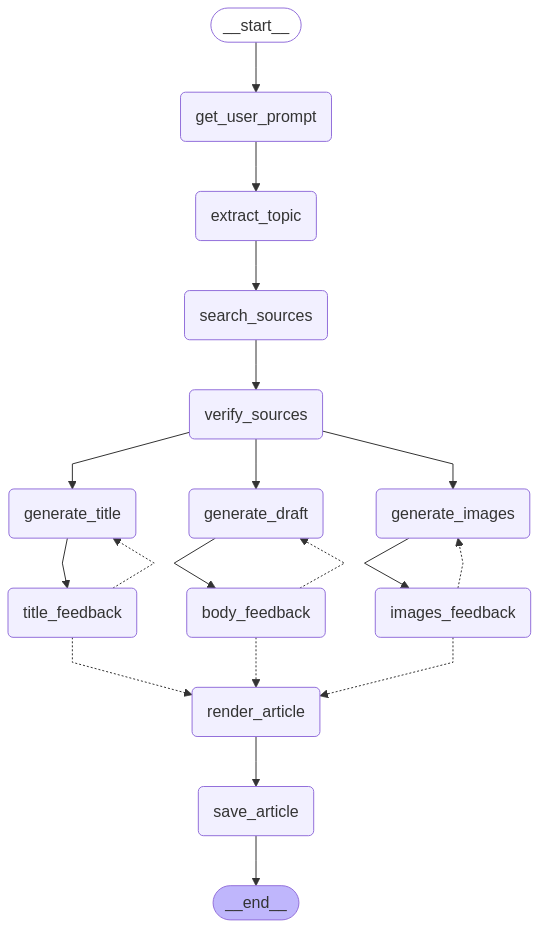

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
nest_asyncio.apply()

async def run_graph_with_feedback():
    config = {"configurable": {"thread_id": uuid.uuid4()}}

    event_stream = graph.astream_events(
        {},
        config,
        version="v2"
    )

    async for event in event_stream:
        node = event['metadata'].get('langgraph_node', '')

        if node == "title_feedback":
            async for ev in graph.astream_events(Command(resume=input("✅ Feedback per il titolo: ")), config):
                pass
        
        elif node == "body_feedback":
            async for ev in graph.astream_events(Command(resume=input("✅ Feedback per il corpo: ")), config):
                pass
        
        elif node == "images_feedback":
            async for ev in graph.astream_events(Command(resume=input("✅ Feedback per le immagini: ")), config):
                pass

await run_graph_with_feedback()
await conn.close()